# HAI DataSet AutoEncoder Model

In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import trange
from TaPR_pkg import etapr

## 데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

In [2]:
TRAIN_DATASET = sorted([x for x in Path("train/").glob("*.csv")])
TRAIN_DATASET

[WindowsPath('train/train1.csv'),
 WindowsPath('train/train2.csv'),
 WindowsPath('train/train3.csv'),
 WindowsPath('train/train4.csv'),
 WindowsPath('train/train5.csv'),
 WindowsPath('train/train6.csv')]

In [3]:
TEST_DATASET = sorted([x for x in Path("test/").glob("*.csv")])
TEST_DATASET

[WindowsPath('test/test1.csv'),
 WindowsPath('test/test2.csv'),
 WindowsPath('test/test3.csv')]

In [4]:
VALIDATION_DATASET = sorted([x for x in Path("validation/").glob("*.csv")])
VALIDATION_DATASET

[WindowsPath('validation/validation.csv')]

In [5]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW는 각각 학습 데이터를 하나의 Pandas Dataframe으로 로드한 결과입니다.
각 필드가 가지는 값의 범위는 크게 다릅니다.
정규화가 필요합니다.

In [6]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


학습 데이터셋은 공격을 받지 않은 평상시 데이터이고 시간을 나타내는 필드인 timestamp가 있으며, 나머지 필드는 모두 비식별화된 센서/액추에이터의 값입니다.
정규화는 센서/액추에이터 필드만을 대상으로 해야 합니다.

본 문서에서는 전체 데이터를 대상으로 이상을 탐지하므로 "attack" 필드만 사용하였습니다.

VALID_COLUMNS_IN_TRAIN_DATASET은 학습 데이터셋에 있는 모든 센서/액추에이터 필드를 담고 있습니다.
가끔 학습 데이터셋에 존재하지 않는 필드가 테스트 데이터셋에 존재하는 경우가 있습니다.
학습 시 보지 못했던 필드에 대해서 테스트를 할 수 없으므로 학습 데이터셋을 기준으로 필드 이름을 얻어냈습니다.

In [7]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

TAG_MIN과 TAG_MAX는 학습 데이터셋에서 최솟값 최댓값을 얻은 결과입니다.

In [8]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

normalize 함수는 Dataframe을 정규화합니다.
정규화 방법은 최솟값, 최댓값을 이용하여 0~1의 범위에 들어오도록 하는 것입니다.

가끔 값이 전혀 변하지 않는 필드가 있습니다.
이 경우 최솟값과 최댓값이 같을 것입니다.
본 문서에서는 이런 필드를 모두 0으로 만들었습니다.

In [9]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

TRAIN_DF는 정규화를 마친 후 exponential weighted function을 통과시킨 결과입니다.
센서에서 발생하는 noise를 smoothing 시켜주기를 기대하고 적용했습니다.

In [10]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


boundary_check 함수는 Pandas Dataframe에 있는 값 중 1 초과의 값이 있는지, 0 미만의 값이 있는지, NaN이 있는지 점검합니다.

In [11]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [12]:
boundary_check(TRAIN_DF)

(False, False, False)

1보다 큰 값, 0보다 작은 값, not a number가 없습니다. 정규화가 정상적으로 처리되었습니다.

# 딥러닝 모델 생성

In [13]:
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [125]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(86, activation='elu', input_shape=(86,)))
model.add(Dense(248, activation='elu'))
model.add(Dense(516, activation='elu'))
model.add(Dense(86, activation='sigmoid'))

In [126]:
import tensorflow as tf 

model.compile( optimizer='Adam',
#              optimizer = tf.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999) ,
             loss= 'MSE',
             metrics=['mae', 'mse', 'acc'])

https://blog.keras.io/building-autoencoders-in-keras.html
https://m.blog.naver.com/qbxlvnf11/221523851461

In [128]:
model.fit(TRAIN_DF, TRAIN_DF, epochs=20, batch_size=10000)

Epoch 1/20
101/101 [==============================] - 7s 67ms/step - loss: 2.4714e-04 - mae: 0.0093 - mse: 2.4714e-04 - acc: 0.4069
Epoch 2/20
101/101 [==============================] - 7s 68ms/step - loss: 2.4309e-04 - mae: 0.0093 - mse: 2.4309e-04 - acc: 0.4082
Epoch 3/20
101/101 [==============================] - 7s 68ms/step - loss: 2.3935e-04 - mae: 0.0092 - mse: 2.3935e-04 - acc: 0.4138
Epoch 4/20
101/101 [==============================] - 7s 68ms/step - loss: 2.3159e-04 - mae: 0.0090 - mse: 2.3159e-04 - acc: 0.4191
Epoch 5/20
101/101 [==============================] - 7s 68ms/step - loss: 2.3011e-04 - mae: 0.0090 - mse: 2.3011e-04 - acc: 0.4205
Epoch 6/20
101/101 [==============================] - 7s 69ms/step - loss: 2.2636e-04 - mae: 0.0089 - mse: 2.2636e-04 - acc: 0.4215
Epoch 7/20
101/101 [==============================] - 7s 69ms/step - loss: 2.2074e-04 - mae: 0.0088 - mse: 2.2074e-04 - acc: 0.4288
Epoch 8/20
101/101 [==============================] - 7s 69ms/step - loss: 2

In [23]:
# 모델 저장
from keras.models import load_model

model.save('Deep_6770.h5')
# model = load_model('mnist_mlp_model.h5')

In [130]:
# 확인!
pred = model.predict(TRAIN_DF)
pred

array([[4.4893941e-01, 2.9918551e-04, 4.7495574e-02, ..., 3.0839443e-04,
        4.3126941e-04, 2.4939725e-01],
       [3.9829817e-01, 3.0353665e-04, 5.2920073e-02, ..., 3.2889843e-04,
        4.4244528e-04, 2.5362545e-01],
       [3.4081957e-01, 3.1462312e-04, 5.3320944e-02, ..., 3.2350421e-04,
        4.4730306e-04, 2.4684057e-01],
       ...,
       [4.1240084e-01, 7.4625015e-04, 4.9243838e-02, ..., 6.2382221e-04,
        5.5763125e-04, 1.7017692e-02],
       [4.1836154e-01, 7.4678659e-04, 4.9461186e-02, ..., 6.0689449e-04,
        5.5563450e-04, 1.6765505e-02],
       [4.4319984e-01, 7.1522593e-04, 4.9044609e-02, ..., 5.7971478e-04,
        5.3238869e-04, 1.6444027e-02]], dtype=float32)

In [131]:
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.448939,0.000299,0.047496,0.506952,0.132589,0.445408,0.823480,0.000216,0.000216,0.000270,...,0.239449,0.190165,0.691617,0.140719,0.171601,0.000749,0.511448,0.000308,0.000431,0.249397
1,0.398298,0.000304,0.052920,0.514204,0.137454,0.386980,0.807270,0.000212,0.000229,0.000293,...,0.239413,0.191329,0.698591,0.138042,0.172492,0.000773,0.508329,0.000329,0.000442,0.253625
2,0.340820,0.000315,0.053321,0.509722,0.147138,0.395229,0.815380,0.000221,0.000231,0.000289,...,0.238566,0.190437,0.693700,0.139118,0.180567,0.000800,0.507103,0.000324,0.000447,0.246841
3,0.460043,0.000290,0.051393,0.518122,0.149677,0.431146,0.818174,0.000202,0.000218,0.000272,...,0.240453,0.188979,0.692597,0.141700,0.185207,0.000733,0.507140,0.000321,0.000429,0.257213
4,0.381164,0.000283,0.057329,0.515424,0.158782,0.412477,0.801381,0.000182,0.000216,0.000270,...,0.245961,0.187303,0.684217,0.144050,0.191734,0.000728,0.513936,0.000306,0.000419,0.255118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004397,0.476751,0.000711,0.048882,0.512972,0.989890,0.518661,0.648684,0.000748,0.000415,0.000555,...,0.404040,0.690217,0.950337,0.996533,0.512830,0.000493,0.411903,0.000613,0.000538,0.017257
1004398,0.434726,0.000749,0.048757,0.508570,0.989487,0.512306,0.649778,0.000757,0.000436,0.000566,...,0.402759,0.690687,0.950258,0.996594,0.515596,0.000512,0.412365,0.000621,0.000557,0.017141
1004399,0.412401,0.000746,0.049244,0.518617,0.989970,0.505768,0.648784,0.000802,0.000424,0.000591,...,0.404191,0.687808,0.950440,0.996506,0.510567,0.000521,0.412586,0.000624,0.000558,0.017018
1004400,0.418362,0.000747,0.049461,0.513555,0.989750,0.522232,0.645618,0.000805,0.000420,0.000571,...,0.405774,0.688767,0.949876,0.996531,0.506543,0.000515,0.410919,0.000607,0.000556,0.016766


In [132]:
sum(sum(pred - np.array(TRAIN_DF)))

-90694.72516100727

## 사전학습 모델

In [31]:
from keras.models import load_model

# model.save('Deep_4356.h5')
model = load_model('Deep_6770.h5')

In [32]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 86)                7482      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                5568      
_________________________________________________________________
dense_41 (Dense)             (None, 866)               56290     
_________________________________________________________________
dense_42 (Dense)             (None, 86)                74562     
Total params: 143,902
Trainable params: 143,902
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 확인!
pred = model.predict(TRAIN_DF)
pred

print(pd.DataFrame(pred).head())

sum(sum(pred - np.array(TRAIN_DF)))

         0         1         2         3         4         5         6   \
0  0.436819  0.000132  0.046970  0.513225  0.131363  0.440633  0.833335   
1  0.383396  0.000110  0.048759  0.521209  0.134702  0.385040  0.821645   
2  0.338877  0.000130  0.050085  0.515178  0.140576  0.388846  0.827105   
3  0.452374  0.000122  0.048602  0.523860  0.145809  0.429490  0.819611   
4  0.390352  0.000126  0.056443  0.529743  0.146343  0.384899  0.804396   

         7         8         9   ...        76        77        78        79  \
0  0.000045  0.000129  0.000108  ...  0.243265  0.195547  0.692524  0.161848   
1  0.000062  0.000108  0.000095  ...  0.244260  0.199024  0.696280  0.161474   
2  0.000050  0.000128  0.000109  ...  0.241565  0.193848  0.689308  0.157927   
3  0.000049  0.000119  0.000100  ...  0.238228  0.198025  0.684860  0.162182   
4  0.000046  0.000124  0.000104  ...  0.239113  0.196874  0.674210  0.164699   

         80        81        82        83        84        85  
0  0

11488.07920313868

# 학습된 모델을 이용한 탐지

검증 데이터셋을 불러와서 모델에 입력으로 주고 예측값과 실제값의 차를 얻어봅니다.

검증 데이터셋에 대해서도 만들어둔 함수를 이용해서 점검해봅니다.
Not a number가 있는지 점검하는 것이 주요 목적입니다.

In [34]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


검증 데이터셋도 정상 데이터셋의 최솟값, 최댓값을 이용해서 정규화합니다.

In [35]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [36]:
boundary_check(VALIDATION_DF)

(True, True, False)

공격 데이터셋에서는 확실히 정상 데이터의 최솟값과 최댓값을 벗어나는 값이 나타나고 있습니다.

In [37]:
VALIDATION_DF.shape

(86400, 86)

In [38]:
## VALIDATION SET PREDICTIONS
y_pred = model.predict(VALIDATION_DF)

In [39]:
arr_val = np.array(VALIDATION_DF)

In [40]:
tmp=[]
for i in range(len(y_pred)):
    tmp.append(abs(arr_val[i]-y_pred[i]))

In [41]:
ANOMALY_SCORE=np.mean(tmp,axis=1)

In [42]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

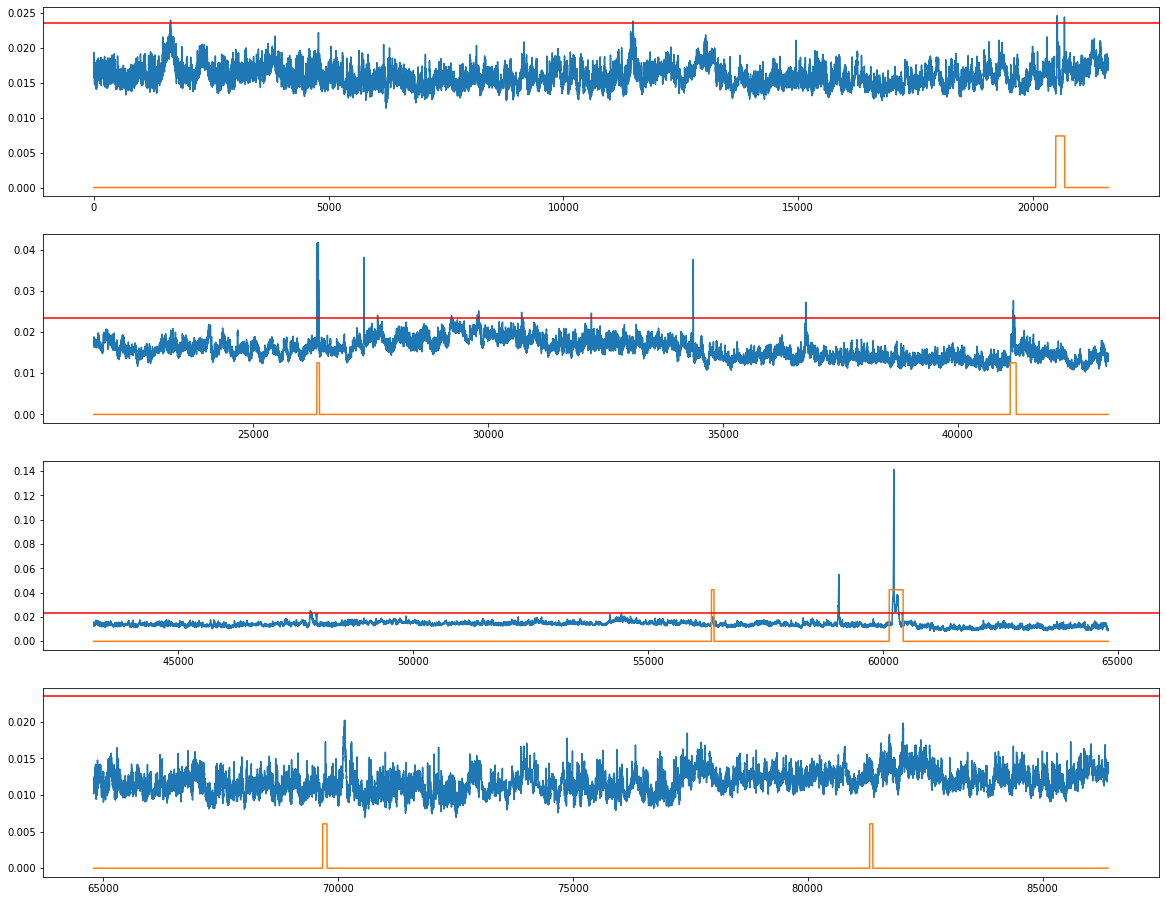

In [44]:
THRESHOLD = 0.0235
check_graph(ANOMALY_SCORE, np.array(VALIDATION_DF_RAW.attack), piece=4, THRESHOLD=THRESHOLD)

In [45]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [46]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (86400,))

In [47]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (86400,))

## 평가

평가는 TaPR을 사용합니다.
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인합니다.

In [48]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.171 (TaP: 0.154, TaR: 0.193)
# of detected anomalies: 2
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x000002782D8C1C40>, <TaPR_pkg.DataManage.Range.Range object at 0x0000027825833670>]


# 테스트 데이터셋 예측
학습 데이터셋과 검증 데이터셋을 이용해 만든 모델로 테스트 데이터셋 결과를 예측합니다.

In [49]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


테스트 데이터셋도 정상 데이터셋의 최솟값, 최댓값을 이용해서 정규화합니다.

In [50]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,...,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,...,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,...,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,...,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,...,0.245764,0.130889,0.240398,0.327644,0.529605,0.0,0.539339,0.0,0.0,0.010225
129596,0.512114,0.0,0.017216,0.461690,0.135262,0.557380,0.711717,0.0,0.0,0.0,...,0.241081,0.131212,0.240398,0.320111,0.540804,0.0,0.539339,0.0,0.0,0.010225
129597,0.553332,0.0,0.017216,0.493026,0.133167,0.590276,0.711717,0.0,0.0,0.0,...,0.240613,0.130586,0.240398,0.306708,0.545617,0.0,0.539339,0.0,0.0,0.010225
129598,0.587329,0.0,0.017216,0.519678,0.132821,0.603950,0.711717,0.0,0.0,0.0,...,0.240566,0.128753,0.240398,0.287885,0.550216,0.0,0.539339,0.0,0.0,0.010225


테스트 데이터셋에 대해서도 만들어둔 함수를 이용해서 점검해봅니다.
Not a number가 있는지 점검하는 것이 주요 목적입니다.

In [51]:
boundary_check(TEST_DF)

(True, True, False)

In [52]:
## VALIDATION SET PREDICTIONS
y_pred = model.predict(TEST_DF)

In [53]:
arr_val1 = np.array(TEST_DF)

In [54]:
tmp=[]
for i in range(len(y_pred)):
    tmp.append(abs(arr_val1[i]-y_pred[i]))

In [55]:
ANOMALY_SCORE=np.mean(tmp,axis=1)

In [56]:
def check_graph1(xs, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
#         if len(xs[L:R]) > 0:
#             peak = max(xs[L:R])
#             axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

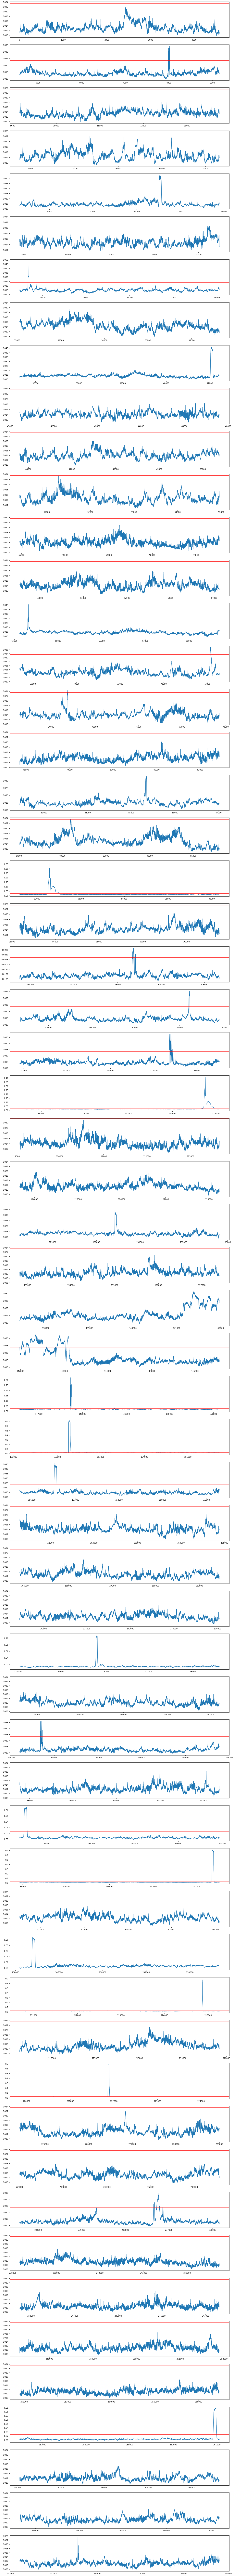

In [62]:
check_graph1(ANOMALY_SCORE, piece=60, THRESHOLD=THRESHOLD)

In [58]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274800,))

In [ ]:
pd.DataFrame(LABELS).value_counts()

## 제출 파일

In [59]:
submission = pd.read_csv('sample_submission.csv')
submission['attack']=LABELS
submission

,timestamp,attack
0,2021-07-13 16:00:01,0.0
1,2021-07-13 16:00:02,0.0
2,2021-07-13 16:00:03,0.0
3,2021-07-13 16:00:04,0.0
4,2021-07-13 16:00:05,0.0
...,...,...
274795,2021-07-16 23:59:56,0.0
274796,2021-07-16 23:59:57,0.0
274797,2021-07-16 23:59:58,0.0
274798,2021-07-16 23:59:59,0.0


In [60]:
submission.to_csv('AU_6770.csv', index=False)

---
**Copyright 2021. Minh-A 연구소. All rights reserved.**